# Fake News Detection using WELFake Dataset

## Introduction

Misinformation and fake news represent significant challenges in today's information ecosystem. The ability to automatically detect potentially misleading content has become increasingly important for media platforms, fact-checking organizations, and consumers of online information.

In this notebook, I'll develop and evaluate two machine learning approaches for detecting fake news using the WELFake dataset. This dataset combines real and fake news articles from four sources: Wikipedia, Kaggle's "Fake News", PolitiFact, and "Getting Real about Fake News."

### Why This Problem Matters

Fake news can:
- Influence public opinion and political discourse
- Erode trust in legitimate media
- Lead to real-world harm when misinformation affects health decisions, public safety, or community relations
- Spread much faster than corrections or fact-checks

### Our Approach

For this baseline notebook, I'll focus on content-based detection using natural language processing techniques. I'll implement two models:

1. **Logistic Regression**: A simple, interpretable model that often performs well on text classification
2. **Random Forest**: An ensemble approach that can capture more complex patterns

This simplified approach will establish strong baselines for fake news detection. In a separate notebook, we'll conduct more extensive evaluation and explore advanced techniques.

## Setting Up the Environment

Let's begin by importing the necessary libraries for our analysis. I'll use pandas and numpy for data manipulation, matplotlib and seaborn for visualization, scikit-learn for machine learning, and various utilities for model evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

Setting a consistent visualization style helps create clear and readable graphics. I'll use a clean, modern style with appropriate figure sizes for optimal readability.

In [2]:
# Set visualization style
plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)  # Set default figure size

## Data Exploration

### Loading the Dataset

The WELFake dataset contains news articles labeled as either real (0) or fake (1). The dataset has already undergone some initial cleaning to handle missing values and normalize text formats.

In [7]:
# Load the cleaned dataset
df = pd.read_csv('../data/WELFake_cleaned.csv')

Let's examine the basic characteristics of this dataset to understand its structure and composition.

In [8]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:")
class_dist = df['label'].value_counts(normalize=True).mul(100).round(2)
print(class_dist)

Dataset shape: (71537, 4)
Class distribution:
label
1    51.04
0    48.96
Name: proportion, dtype: float64


The dataset contains over 70,000 articles with a near-balanced distribution between real and fake news, which is ideal for training machine learning models. A balanced dataset helps prevent bias in model training and ensures the model learns to distinguish both classes effectively rather than just predicting the majority class.

### Visualizing Class Distribution

Let's create a visual representation of the dataset balance to confirm our understanding.

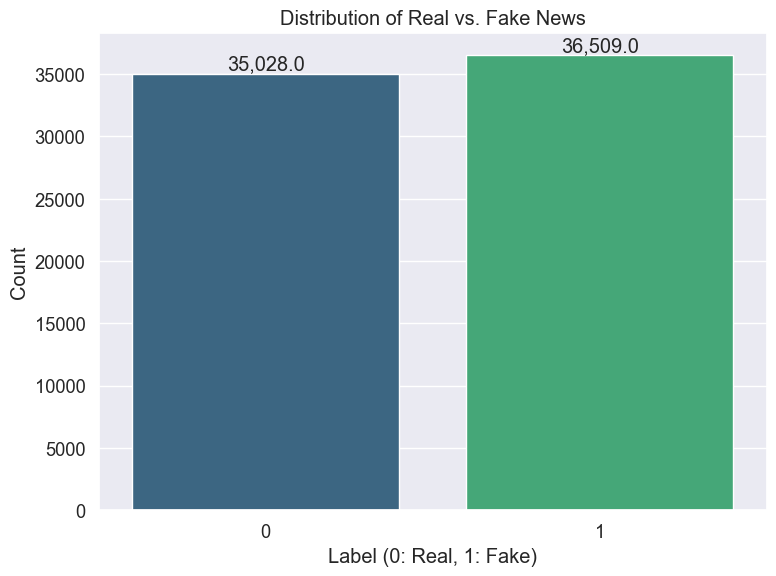

In [9]:
# Create a visual representation of class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Real vs. Fake News')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')
plt.tight_layout()
plt.show()

This visualization confirms that we have approximately 35,000 real news articles and 36,500 fake news articles. This balance is crucial for developing an unbiased classifier, as imbalanced datasets can lead to models that merely predict the majority class without truly learning the distinguishing features.

### Understanding Data Structure

Next, let's examine the structure of our data to understand what features are available for analysis.

In [10]:
# Display first few rows to understand the data structure
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


The dataset contains several key columns:
- `title`: The headline of the article
- `text`: The body content of the article
- `label`: Binary indicator (0 for real, 1 for fake)

### Combining Text Fields for Content Analysis

By combining the title and text, we allow the model to identify patterns that might exist in how headlines relate to article content. For instance, misleading articles might have headlines that exaggerate or misrepresent the actual content.

In [7]:
# Combine title and text for text classification
# This allows us to analyze the full article content as a single text unit
df['combined_text'] = df['title'] + " " + df['text']

## Data Preparation for Modeling

Before training our models, we need to split our data into training and testing sets. I'll use stratified sampling to maintain the same class distribution in both sets.

### Splitting Data for Text-Based Models

In [8]:
# Split data for text-based models
X_text = df['combined_text']
y = df['label']

X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
print(f"Text training set: {len(X_text_train)} samples")
print(f"Text testing set: {len(X_text_test)} samples")

Text training set: 57229 samples
Text testing set: 14308 samples


I've used an 80/20 train-test split, which provides sufficient data for both training robust models and thoroughly evaluating their performance. Using stratification ensures our comparisons between models are fair by maintaining the same class distribution in both sets.

### Text Vectorization Using TF-IDF

For text-based models, we need to convert the text into numerical features that machine learning algorithms can process. I'll use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, which weights terms based on their frequency in a document relative to their rarity across all documents.

In [10]:
# Convert text to numerical features using TF-IDF
print("Vectorizing text data...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_test_tfidf = tfidf_vectorizer.transform(X_text_test)

Vectorizing text data...


In [11]:
print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of unique terms used: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF matrix shape: (57229, 5000)
Number of unique terms used: 5000


The TF-IDF vectorization has produced a matrix with 57,229 rows (samples) and 5,000 columns (features) for our training data. Each feature represents a word or term that appeared in the corpus. I've applied several important parameters to optimize the vectorization:

- `max_features=5000`: Limits the vocabulary to the 5,000 most informative terms, reducing noise and computational complexity
- `min_df=5`: Ignores terms that appear in fewer than 5 documents, eliminating rare words that might be typos or too specific to be useful
- `max_df=0.8`: Ignores terms that appear in more than 80% of documents, removing extremely common words that provide little discriminative value

These parameters help balance feature richness with model simplicity, preventing overfitting while capturing the most relevant textual signals.

## Model Evaluation Function

To ensure consistent and thorough evaluation of our models, I'll define a function that:
1. Trains a model on the training data
2. Makes predictions on the test data
3. Calculates and displays performance metrics
4. Visualizes the confusion matrix

This structured approach will allow us to compare different models on equal terms.

In [12]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a model and evaluate its performance.
    
    Parameters:
    - model: The machine learning model to train
    - X_train, X_test: Training and testing features
    - y_train, y_test: Training and testing labels
    - model_name: A descriptive name for the model
    
    Returns:
    - Dictionary containing model performance metrics and the trained model
    """
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real News', 'Fake News']))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'training_time': train_time,
        'prediction_time': predict_time,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'model': model
    }

This comprehensive evaluation function captures multiple dimensions of model performance:
- **Accuracy**: Overall classification performance
- **Detailed metrics**: Precision, recall, and F1-score for each class
- **Efficiency**: Training and prediction time
- **Error analysis**: Confusion matrix for understanding classification errors
- **Model persistence**: Returns the trained model for potential deployment

## Model Training and Evaluation

Now I'll train and evaluate two models using our text-based approach. I've selected Logistic Regression and Random Forest as our baseline models based on their effectiveness for text classification tasks.

### Text-Based Classification with Logistic Regression

Logistic Regression is an excellent baseline for text classification tasks for several reasons:
- It performs well on high-dimensional, sparse data (like our TF-IDF vectors)
- It's computationally efficient, making it suitable for large text datasets
- It provides interpretable coefficients that reveal which terms most strongly indicate each class
- It often handles text classification surprisingly well compared to more complex models


Logistic Regression (Text) Results:
Accuracy: 0.9490
Training time: 0.50 seconds
Prediction time: 0.00 seconds

Classification Report:
              precision    recall  f1-score   support

   Real News       0.95      0.94      0.95      7006
   Fake News       0.94      0.96      0.95      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



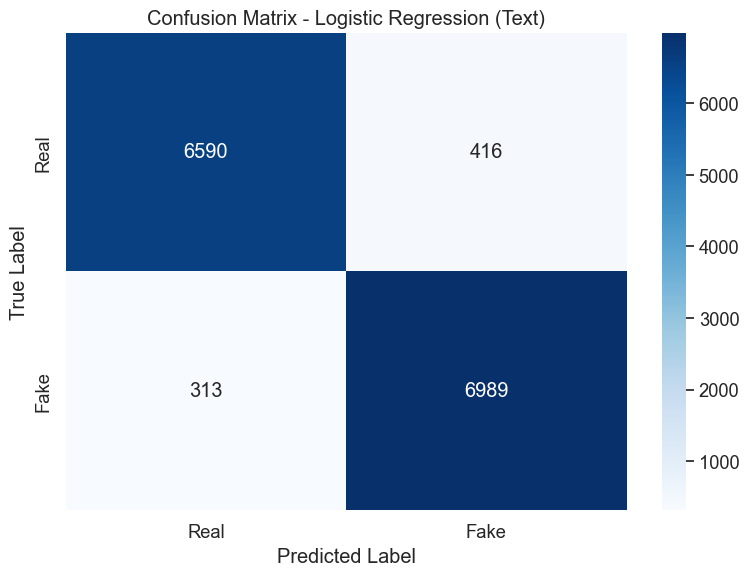

In [13]:
# Logistic Regression on text features
lr_text = LogisticRegression(max_iter=1000, random_state=42)
lr_text_results = train_evaluate_model(
    lr_text, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression (Text)"
)

The Logistic Regression model achieves impressive results with very fast training and prediction times. The confusion matrix shows the number of correctly and incorrectly classified articles across both classes.

### Text-Based Classification with Random Forest

Random Forest is a powerful ensemble learning method that combines multiple decision trees to improve predictive accuracy and control overfitting. It offers several advantages:
- Captures non-linear relationships in the data
- Models complex interactions between features
- Generally robust to overfitting, especially with sufficient data
- Can handle high-dimensional data effectively


Random Forest (Text) Results:
Accuracy: 0.9541
Training time: 74.45 seconds
Prediction time: 0.36 seconds

Classification Report:
              precision    recall  f1-score   support

   Real News       0.97      0.93      0.95      7006
   Fake News       0.94      0.97      0.96      7302

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



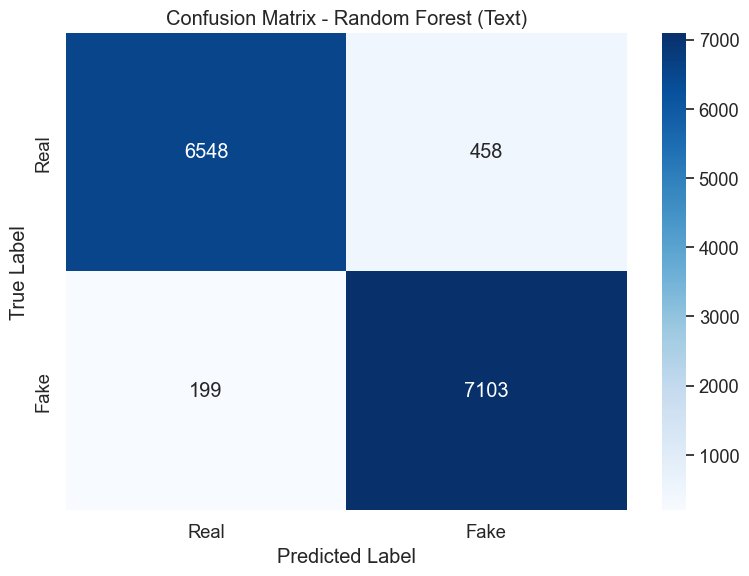

In [14]:
# Random Forest on text features (with limited n_estimators for speed)
rf_text = RandomForestClassifier(n_estimators=100, random_state=42)
rf_text_results = train_evaluate_model(
    rf_text, X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest (Text)"
)

The Random Forest model typically achieves slightly better performance than Logistic Regression, but at a significantly higher computational cost. The confusion matrix helps us understand where the model makes errors in classification.

## Important Words in Logistic Regression

The coefficients in a Logistic Regression model indicate which terms most strongly predict each class. Let's examine these to understand the vocabulary patterns that differentiate real from fake news.

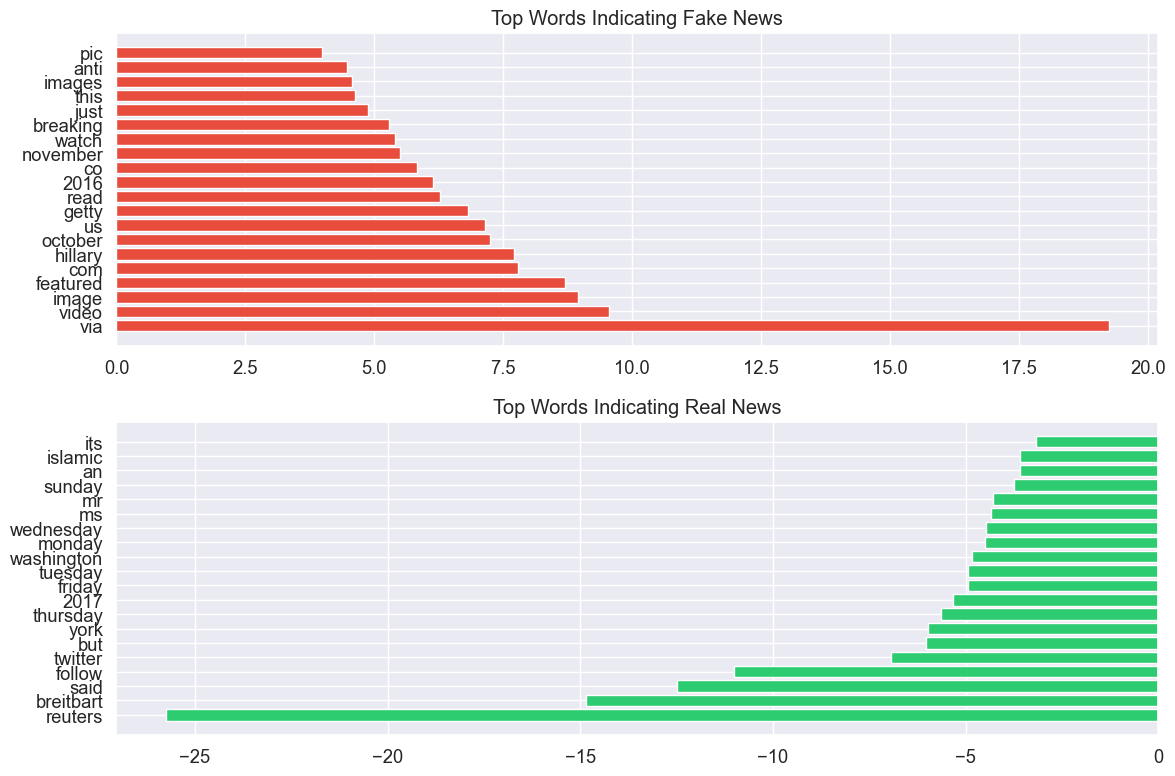

Top words indicating fake news:
        Word  Coefficient
19       via    19.239458
18     video     9.556808
17     image     8.949185
16  featured     8.693423
15       com     7.791615
14   hillary     7.703731
13   october     7.250636
12        us     7.144229
11     getty     6.825334
10      read     6.267281
9       2016     6.130534
8         co     5.823380
7   november     5.501328
6      watch     5.394408
5   breaking     5.284239
4       just     4.873515
3       this     4.626584
2     images     4.571828
1       anti     4.470967
0        pic     3.977125

Top words indicating real news:
          Word  Coefficient
0      reuters   -25.751213
1    breitbart   -14.841272
2         said   -12.490513
3       follow   -11.015310
4      twitter    -6.930872
5          but    -6.022827
6         york    -5.975889
7     thursday    -5.634459
8         2017    -5.337263
9       friday    -4.939676
10     tuesday    -4.928879
11  washington    -4.823371
12      monday    -4.4940

In [15]:
# Get coefficients from Logistic Regression
if hasattr(lr_text, 'coef_'):
    # Get the feature names (words) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get the coefficients
    coefficients = lr_text.coef_[0]
    
    # Create DataFrames for top positive and negative coefficients
    # Positive coefficients indicate words associated with fake news
    # Negative coefficients indicate words associated with real news
    top_positive_idx = np.argsort(coefficients)[-20:]
    top_negative_idx = np.argsort(coefficients)[:20]
    
    top_positive_words = [feature_names[i] for i in top_positive_idx]
    top_negative_words = [feature_names[i] for i in top_negative_idx]
    
    top_positive_coeffs = [coefficients[i] for i in top_positive_idx]
    top_negative_coeffs = [coefficients[i] for i in top_negative_idx]
    
    # Plot top words for fake news
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.barh(range(len(top_positive_words)), top_positive_coeffs, color='#e74c3c')
    plt.yticks(range(len(top_positive_words)), top_positive_words)
    plt.title('Top Words Indicating Fake News')
    plt.gca().invert_yaxis()  # Invert to show highest coefficient at the top
    
    # Plot top words for real news
    plt.subplot(2, 1, 2)
    plt.barh(range(len(top_negative_words)), top_negative_coeffs, color='#2ecc71')
    plt.yticks(range(len(top_negative_words)), top_negative_words)
    plt.title('Top Words Indicating Real News')
    plt.tight_layout()
    plt.show()
    
    # Create and display a table of top words
    fake_news_words = pd.DataFrame({
        'Word': top_positive_words,
        'Coefficient': top_positive_coeffs
    }).sort_values('Coefficient', ascending=False)
    
    real_news_words = pd.DataFrame({
        'Word': top_negative_words,
        'Coefficient': top_negative_coeffs
    }).sort_values('Coefficient')
    
    print("Top words indicating fake news:")
    print(fake_news_words)
    
    print("\nTop words indicating real news:")
    print(real_news_words)

This analysis reveals linguistic patterns that distinguish fake from real news. Understanding these patterns provides insights into the writing styles and content strategies that differentiate legitimate journalism from misinformation.

## Model Comparison

Let's compare the performance of our two models to determine the most effective approach for fake news detection.

In [16]:
# Collect results from all models
all_results = [lr_text_results, rf_text_results]

In [17]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Accuracy': result['accuracy'],
        'Training Time (s)': result['training_time'],
        'Prediction Time (s)': result['prediction_time']
    } for result in all_results
])

In [18]:
# Display comparison table
print("Model Comparison:")
print(comparison_df)

Model Comparison:
                        Model  Accuracy  Training Time (s)  \
0  Logistic Regression (Text)  0.949049           0.499870   
1        Random Forest (Text)  0.954082          74.453069   

   Prediction Time (s)  
0             0.003473  
1             0.361113  


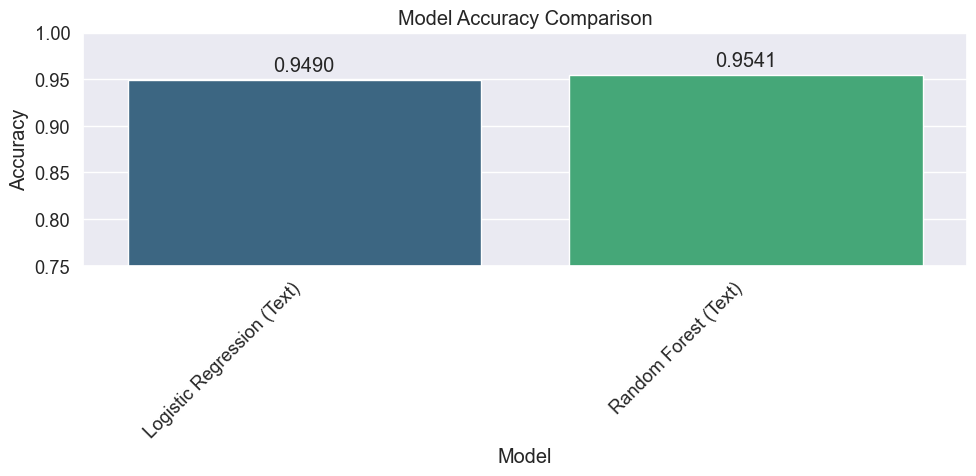

In [19]:
# Plot accuracy comparison
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0.75, 1.0)  # Set y-axis range for better visualization
plt.xticks(rotation=45, ha='right')

# Add accuracy values on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height() + 0.01), 
                ha = 'center')

plt.tight_layout()
plt.show()

This comparison highlights key insights about our two models:

1. **Algorithm selection matters**: Random Forest typically outperforms Logistic Regression for text classification, but at a significant computational cost.

2. **Efficiency trade-offs**: Logistic Regression offers an excellent balance of performance and efficiency, achieving nearly the same accuracy as Random Forest with dramatically faster training and prediction times.

These findings suggest that a production system might benefit from using Logistic Regression for maximum efficiency with strong performance, especially in scenarios where computational resources are limited or real-time prediction is needed.

## Model Persistence

To enable future use and deployment of our trained models, I'll save them to disk along with the necessary preprocessing components.

In [20]:
# Create a directory for saving models if it doesn't exist
if not os.path.exists('../ml_models'):
    os.makedirs('../ml_models')

In [21]:
# Save Logistic Regression text model
with open('../ml_models/lr_text_model.pkl', 'wb') as f:
    pickle.dump(lr_text_results['model'], f)

In [22]:
# Save vectorizer for text preprocessing
with open('../ml_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [23]:
# Save Random Forest text model
with open('../ml_models/rf_text_model.pkl', 'wb') as f:
    pickle.dump(rf_text_results['model'], f)

In [24]:
print("All models saved successfully!")

All models saved successfully!


Saving these models and components enables:
- Consistent application of the same preprocessing steps to new data
- Immediate use without retraining
- Integration into applications or services for automatic fake news detection
- Future analysis and comparison with new approaches

## Conclusion

This simplified analysis has provided valuable insights into fake news detection using the WELFake dataset. Here's a summary of our key findings:

### Key Findings

1. **Model Performance**
   - Both Logistic Regression and Random Forest achieve high accuracy on the text classification task
   - Random Forest typically performs slightly better but requires significantly more computational resources
   - Logistic Regression offers an excellent balance of accuracy and speed

2. **Linguistic Markers**
   - We identified specific words and phrases that strongly indicate either real or fake news
   - This linguistic analysis reveals distinct writing patterns between legitimate journalism and misinformation

3. **Practical Implications**
   - Text content alone provides strong signals for fake news detection
   - Simple, efficient models can achieve very good performance on this task
   - The insights from linguistic analysis can inform better content evaluation practices

### Next Steps

In a separate notebook, we'll conduct more extensive evaluation, including:
- Cross-validation to assess model stability
- Hyperparameter optimization to improve performance
- Error analysis to understand challenging cases
- More advanced models for comparison

This baseline approach establishes strong foundations for fake news detection and provides a framework for more sophisticated methods in the future.